## Cargar librerías

In [93]:
import matplotlib.pyplot as plt
import requests, re, os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import contextily as ctx

## Cambiar directorio

In [3]:
#os.chdir("/content/drive/MyDrive/PRONACES/python")
#Show directory
os.getcwd()

'c:\\Users\\pedro\\Documents\\programación\\python\\pronaces_analisis'

## Lista de archivos RETC

In [4]:
retcFiles = glob.glob("data/RETC_2004-2020/raw/*.xlsx")
retcFiles[:5]

['data/RETC_2004-2020/raw\\Inconsistencias_2004.xlsx',
 'data/RETC_2004-2020/raw\\Inconsistencias_2006.xlsx',
 'data/RETC_2004-2020/raw\\Inconsistencias_2007.xlsx',
 'data/RETC_2004-2020/raw\\Inconsistencias_2008.xlsx',
 'data/RETC_2004-2020/raw\\Inconsistencias_2009.xlsx']

In [5]:
unidades = {
    "ton":1,
    "ton/año":1,
    "kg":1/1000,
    "Kg":1/1000,
    "kg/año":1/1000,
    "g":1/(1000*1000),
    
}
columnasContaminantes = [
    'AIRE', 'AGUA', 'SUELO', 'REUTILIZACIÓN', 'RECICLADO',
    'COPROCESAMIENTO', 'TRATAMIENTO', 'DISPOSICIÓN\nFINAL',
    'ALCANTARILLADO', 'INCINERACIÓN', 'OTROS']

rename_columns = {
    "delegación\municipio":"municipio",
    'coordenada\nutm x':'coordenada utm x', 
    'coordenada\nutm y':'coordenada utm y',
    'coordenada \nutm x':"coordenada utm x", 
    'coordenada \nutm y':"coordenada utm y",
    'latitud \nnorte' :'latitud norte',  
    'longitud \noeste':'longitud oeste',
    'número exterior':'núm. ext',
    'número interior':'núm. int',
    'no. exterior':'núm. ext', 
    'no. interior':'núm. int',
    'c.p.':"código postal",
    'clave\nambiental':'clave ambiental',
    'principal actividad productiva':'actividad principal',
    "descripción":"sustancia",
    "no. cas":"cas",
    "entidad federativa":"estado",
    "sustancias":"sustancia",
    "disposición\nfinal":"disposición final",
    "otros":"otro"
    }

col_emisiones = ['aire', 'agua', 'suelo', 'reuso']
col_transferencia = ['reciclado', 'coprocesamiento',
  'tratamiento', 'disposición final', 'alcantarillado', 'otro',
  'incineración', 'reutilización']

col_emisiones + col_transferencia

['aire',
 'agua',
 'suelo',
 'reuso',
 'reciclado',
 'coprocesamiento',
 'tratamiento',
 'disposición final',
 'alcantarillado',
 'otro',
 'incineración',
 'reutilización']

## Read metadata RETC

In [6]:
retcEmpresas = pd.DataFrame()
for file in retcFiles:
  df = pd.read_excel(file, sheet_name=0)
  try:
    index = df[df.iloc[:,0] == 'NRA'].index[0]
  except IndexError:

    df.columns = df.columns.str.lower()
    df.rename(columns=rename_columns, inplace=True)
    #df["unidad"].replace(unidades, inplace=True)
    df = df[df['estado'] == 'COLIMA']
    retcEmpresas = pd.concat([retcEmpresas, df], ignore_index=True)
    continue
  
  header = df.iloc[df[df.iloc[:,0] == 'NRA'].index[0]]
  df.columns = header
  
  df = df.iloc[index+1:]
  df.columns = df.columns.str.lower()
  df.rename(columns=rename_columns, inplace=True)
  
  df = df[df["estado"] == "COLIMA"]
  retcEmpresas = pd.concat([retcEmpresas, df], axis=0, ignore_index=True)
  


In [7]:
  
retcEmpresas.sort_values(by="nra", inplace=True, ignore_index=True)


In [80]:
dfEmpresas = pd.DataFrame()
for i, df_complementario in retcEmpresas.groupby('nra'):
  df_complementario.reset_index(drop=True, inplace=True)
  cols_to_keep = ["nra",'latitud norte', 'longitud oeste']
  df_complementario = df_complementario[cols_to_keep]
  
  df_complementario.drop_duplicates(inplace=True)
  #df_complementario.loc[:, "nombre"] = df_complementario['nombre'][0]
  #df_complementario['nombre'] = df_complementario['nombre'][0]
  
  dfEmpresas = pd.concat([dfEmpresas, df_complementario], ignore_index=True)


C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\662245285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complementario.drop_duplicates(inplace=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\662245285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complementario.drop_duplicates(inplace=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\662245285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complem

In [85]:
# load extend
extend = gpd.read_file("data/RETC_2004-2020/extend_colima.gpkg")
extend

,geometry
0,"POLYGON ((-11658583.824 2142453.800, -11657519..."


In [87]:
import re
lat = '''104°19'6"'''

def angleString(angle):
    
    # if angle is formatted as a float, return it
    try:
        deg, minutes, seconds, direction =  re.split('[°\'"]+', angle)
        return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

    except:
        return float(angle)
  
dfEmpresas["lat"] = dfEmpresas["latitud norte"].map(angleString)
dfEmpresas["lon"] = dfEmpresas["longitud oeste"].map(angleString)*-1

gdfEmpresas = gpd.GeoDataFrame(dfEmpresas, geometry=gpd.points_from_xy(dfEmpresas.lon, dfEmpresas.lat), crs="EPSG:4326")
gdfEmpresas = gdfEmpresas.to_crs(epsg=3857)

gdfEmpresas.drop(columns=["latitud norte", "longitud oeste", "lat", "lon"], inplace=True)

# keep points inside extend
gdfEmpresas = gpd.sjoin(gdfEmpresas, extend, how="inner", op="within")
#gdfEmpresas.drop_duplicates(subset='nombre',inplace=True)

C:\Users\pedro\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [83]:
gdfEmpresas.describe()

,lat,lon
count,94.000000,94.000000
mean,19.092153,-94.098918
std,0.127081,43.109692
min,18.842778,-104.681111
25%,18.987917,-104.283889
50%,19.077083,-103.882222
75%,19.210417,-103.751250
max,19.388889,104.277070


<AxesSubplot:>

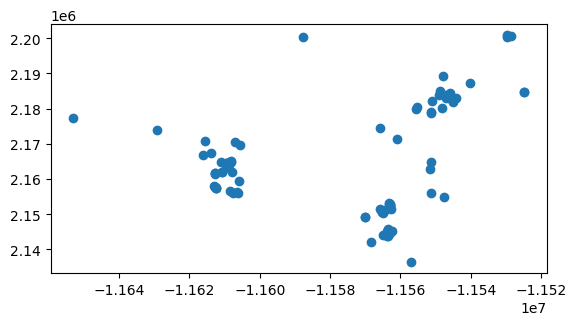

In [88]:

gdfEmpresas.plot()

## Read RETC file

In [11]:
retcEmisiones = pd.DataFrame()
for file in retcFiles:
  year = file[-9:-5]
  # read excel file and use second sheet
  df = pd.read_excel(file, sheet_name=1)
  try:
    index = df[df.iloc[:,0] == 'NRA'].index[0]
  
  except IndexError:
    df['year'] = year
    df.columns = df.columns.str.lower()
    df.rename(columns=rename_columns, inplace=True)
    df["unidad"].replace(unidades, inplace=True)
    df = df[df['estado'] == 'COLIMA']
    retcEmisiones = pd.concat([retcEmisiones, df], ignore_index=True)
    continue

  header = df.iloc[df[df.iloc[:,0] == 'NRA'].index[0]]
  df.columns = header
  
  df = df.iloc[index+1:]
  # remove rows over df[df.iloc[:,0] == 'NRA'].index[0]
  #df = df[:df[df.iloc[:,0] == 'NRA'].index[0]]
  df['year'] = year
  df.columns = df.columns.str.lower()
  df.rename(columns=rename_columns, inplace=True)
  df["unidad"].replace(unidades, inplace=True)
  df = df[df['estado'] == 'COLIMA']
  retcEmisiones = pd.concat([retcEmisiones, df], ignore_index=True)
  
  
for col in col_emisiones + col_transferencia:
  try:
    retcEmisiones[col] = retcEmisiones[col] * retcEmisiones["unidad"]  
  except:
    continue
#retcEmisiones = retcEmisiones[retcEmisiones['estado'] == 'COLIMA']
retcEmisiones.head()

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,tratamiento,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia
0,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD, CENTRAL TERM...",COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,0.001,22288040,0,0,...,0,0,0,0,0,2013,Manzanillo,0,NaN,NaN
1,PREM90600723,PEMEX REFINACION TERMINAL DE ALMACENAMIENTO MA...,COLIMA,Petroleo y petroquimica,Acroleina,107-02-8,0.001,195282,0,0,...,0,0,0,0,0,2013,Manzanillo,0,NaN,NaN
2,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Cromo (compuestos),S/C3,0.001,1727.39,0,0,...,0,0,0.0436,0,0,2013,Manzanillo,0,NaN,NaN
3,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD,COMPLEJO TERM...",COLIMA,Generación de energia electrica,Arsénico (compuestos),As,0.001,0.0,2729.2575,0.0,...,0.0,0.0,0.0,0.0,0.0,2014,Manzanillo,0.0,NaN,NaN
4,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD,COMPLEJO TERM...",COLIMA,Generación de energia electrica,Cadmio (compuestos),Cd,0.001,0.0,27292.5752,0.0,...,0.0,0.0,0.0,0.0,0.0,2014,Manzanillo,0.0,NaN,NaN


In [12]:
col_emisiones + col_transferencia

['aire',
 'agua',
 'suelo',
 'reuso',
 'reciclado',
 'coprocesamiento',
 'tratamiento',
 'disposición final',
 'alcantarillado',
 'otro',
 'incineración',
 'reutilización']

In [13]:
dfFinal = pd.DataFrame()
for index, df in retcEmisiones.groupby("nra"):
  # fill NaN values in "nombre" using the first value
  df['nombre'].fillna(method='ffill', inplace=True)
  df[col_emisiones + col_transferencia].fillna(0, inplace=True)

  dfFinal = pd.concat([dfFinal, df], ignore_index=True)
  
  
for col in col_emisiones + col_transferencia:
  dfFinal[col] = dfFinal[col].astype(float)
  
dfFinal

C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\519342485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_emisiones + col_transferencia].fillna(0, inplace=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\519342485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_emisiones + col_transferencia].fillna(0, inplace=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_7728\519342485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,tratamiento,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia
0,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Xileno (mezcla de isómeros),1330-20-7,0.001,1320.110000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN
1,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Benceno,71-43-2,0.001,543.020000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN
2,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Benceno,71-43-2,0.001,888.501900,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN
3,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Tolueno,108-88-3,0.001,1309.860000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN
4,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Xileno (mezcla de isómeros),1330-20-7,0.001,2058.420000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,1.0,0.000015,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN
1250,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Níquel (compuestos),S/C5,0.001,2350.630000,0.0,0.0,...,0.0,0.0,0.021800,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN
1251,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Arsénico (compuestos),S/C1,0.001,0.000000,0.0,0.0,...,0.0,0.0,0.004818,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN
1252,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Cadmio (compuestos),S/C2,0.001,0.000000,0.0,0.0,...,0.0,0.0,0.002180,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN


In [14]:
rename_sustancias = {
  'Arsénico (compuestos)':'Arsénico',
  'Cadmio (compuestos)':'Cadmio',
  'Cromo (polvos respirables, humos o vapores)': 'Cromo',
  'Cromo (compuestos)': 'Cromo',
  'Mercurio (compuestos)': 'Mercurio',
  'Níquel (polvos respirables, humos o vapores)': 'Níquel',
  'Níquel (compuestos)': 'Níquel',
  'Plomo (compuestos)': 'Plomo',
  'Plomo (polvos respirables, humos o vapores)': 'Plomo',
}
dfFinal["sustancia"].replace(rename_sustancias, inplace=True)

In [15]:
quimicos_to_remove = [
  'Bióxido de carbono','Oxido nitroso','Bióxido de nitrógeno','Metano',
]

In [16]:
dfFinal = dfFinal[~dfFinal["sustancia"].isin(quimicos_to_remove)].copy()

In [17]:


# replace "municipio" values
rename_municipios = {
  "Tecoman": "Tecomán",
  "Minatitlan": "Minatitlán",
  "Cuauhtemoc": "Cuauhtémoc",
  'Villa de Alvarez':"Villa de Álvarez",
  'Ixtlahuacan':"Ixtlahuacán",
  'Coquimatlan':"Coquimatlán",
}

dfFinal["municipio"].replace(rename_municipios, inplace=True)
dfFinal["municipio"].unique()

array(['Manzanillo', nan, 'Tecomán', 'Colima', 'Minatitlán',
       'Coquimatlán', 'Cuauhtémoc', 'Villa de Álvarez', 'Ixtlahuacán'],
      dtype=object)

# Panorama general de los datos

In [18]:
col_emisiones

['aire', 'agua', 'suelo', 'reuso']

In [19]:
# create a new column with the sum of col_emisiones
dfFinal["emisiones"] = dfFinal[col_emisiones].sum(axis=1)
dfFinal[col_emisiones] 

,aire,agua,suelo,reuso
0,1320.1100,0.0,0.0,NaN
1,543.0200,0.0,0.0,NaN
2,888.5019,0.0,0.0,NaN
3,1309.8600,0.0,0.0,NaN
4,2058.4200,0.0,0.0,NaN
...,...,...,...,...
1248,0.0000,0.0,0.0,NaN
1250,2350.6300,0.0,0.0,NaN
1251,0.0000,0.0,0.0,NaN
1252,0.0000,0.0,0.0,NaN


In [20]:
dfFinal.head()

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia,emisiones
0,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Xileno (mezcla de isómeros),1330-20-7,0.001,1320.1100,0.0,0.0,...,0.0,0.0,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,1320.1100
1,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Benceno,71-43-2,0.001,543.0200,0.0,0.0,...,0.0,0.0,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,543.0200
2,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Benceno,71-43-2,0.001,888.5019,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,888.5019
3,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Tolueno,108-88-3,0.001,1309.8600,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,1309.8600
4,AAA0600700317,"KRISHNA LUIS ABRAJAN ALVAREZ,KRISHNA LUIS ABRA...",COLIMA,Petroleo y petroquimica,Xileno (mezcla de isómeros),1330-20-7,0.001,2058.4200,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,2058.4200


In [21]:
dfFinal.sector.unique()

dfFinal["sector"].replace({
  'Bebidas y tabaco':'Bebidas y \ntabaco', 
  'Generación de energia electrica':'Generación de \nenergía eléctrica',
  'Petroleo y petroquimica':'Petróleo y \npetroquímica',
  'Metalurgica (incluye la siderurgica)':'Metalúrgica \n(incluye la siderúrgica)',
  'Alimenticio y/o de consumo humano':'Alimenticio y/o \nde consumo humano', 
  'Quimica':'Química',
  'Tratamiento de residuos peligrosos':'Tratamiento de \nresiduos peligrosos',
  'Petroleo y petroquimica ':'Petróleo y \npetroquímica',
  'Metalurgica (incluye la siderurgica) ':'Metalúrgica \n(incluye la siderúrgica)',
  'Automotriz ':'Automotriz'
  }, inplace=True)

In [22]:
dfFinal['nombre'] = dfFinal['nombre'].str.title()

In [23]:
dfFinal2 = pd.DataFrame()
for i, df_complementario in dfFinal.groupby('nra'):
  df_complementario.reset_index(drop=True, inplace=True)
  df_complementario['nombre'] = df_complementario['nombre'][0]
  
  dfFinal2 = pd.concat([dfFinal2, df_complementario], ignore_index=True)
dfFinal2

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia,emisiones
0,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Xileno (mezcla de isómeros),1330-20-7,0.001,1320.1100,0.0,0.0,...,0.0,0.000000,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,1320.1100
1,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Benceno,71-43-2,0.001,543.0200,0.0,0.0,...,0.0,0.000000,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,543.0200
2,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Benceno,71-43-2,0.001,888.5019,0.0,0.0,...,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,888.5019
3,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Tolueno,108-88-3,0.001,1309.8600,0.0,0.0,...,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,1309.8600
4,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Xileno (mezcla de isómeros),1330-20-7,0.001,2058.4200,0.0,0.0,...,0.0,0.000000,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,2058.4200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,ZEPQY0600711,Zeta Gas Del Pacifico S.A. De C.V.,COLIMA,Petróleo y \npetroquímica,Cianuro inorgánico/orgánico,57-12-5,0.001,0.0000,0.0,0.0,...,0.0,0.109000,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN,0.0000
1040,ZEPQY0600711,Zeta Gas Del Pacifico S.A. De C.V.,COLIMA,Petróleo y \npetroquímica,Níquel,S/C5,0.001,2350.6300,0.0,0.0,...,0.0,0.021800,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN,2350.6300
1041,ZEPQY0600711,Zeta Gas Del Pacifico S.A. De C.V.,COLIMA,Petróleo y \npetroquímica,Arsénico,S/C1,0.001,0.0000,0.0,0.0,...,0.0,0.004818,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN,0.0000
1042,ZEPQY0600711,Zeta Gas Del Pacifico S.A. De C.V.,COLIMA,Petróleo y \npetroquímica,Cadmio,S/C2,0.001,0.0000,0.0,0.0,...,0.0,0.002180,0.0,0.0,2013,Manzanillo,0.0,NaN,NaN,0.0000


In [24]:
df1 = dfFinal2.groupby(by=['municipio','sustancia'], as_index=False).agg({'emisiones':'sum'}).sort_values(by='emisiones', ascending=False)
df1.sort_values(by=['municipio','sustancia'], inplace=True)
len(df1.sustancia.unique())

20

In [25]:
df1.to_excel('data/RETC_2004-2020/emisiones_municipios.xlsx', index=False)

In [26]:
# generate a pallette with 20 random colors
pallette = sns.color_palette("hls", 20)

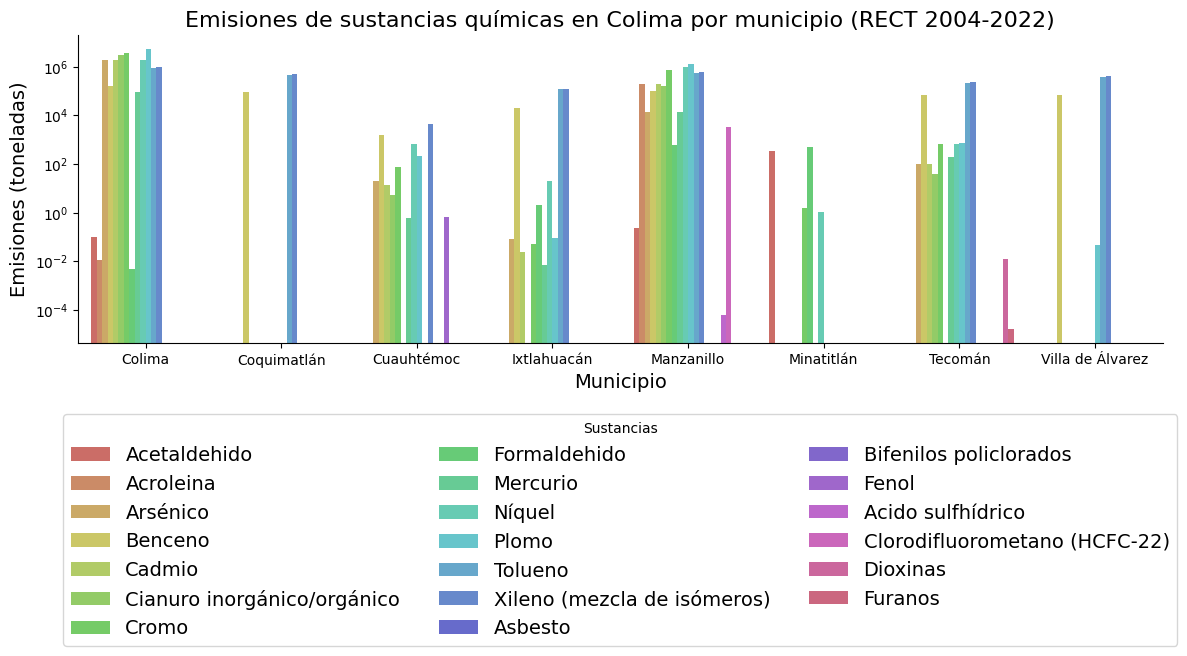

In [27]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por municipio (RECT 2004-2022)", fontsize=16)
# put values in log scale
# set scale to log
sns.barplot(x="municipio", y="emisiones", data=df1, hue="sustancia", ax=ax, log=True, palette=pallette)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Municipio", fontsize=14)

# add beautiful legend
# set title to legend 
ax.legend(title='Sustancias',loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=14)
sns.despine()
plt.savefig('img/RETC_2004-2020/emisiones_municipios.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
df2 = dfFinal2.groupby(by=['sector','municipio'], as_index=False).agg({'emisiones':'sum'}).sort_values(by='emisiones', ascending=False)
df2.sort_values(by=['sector','municipio'], inplace=True)

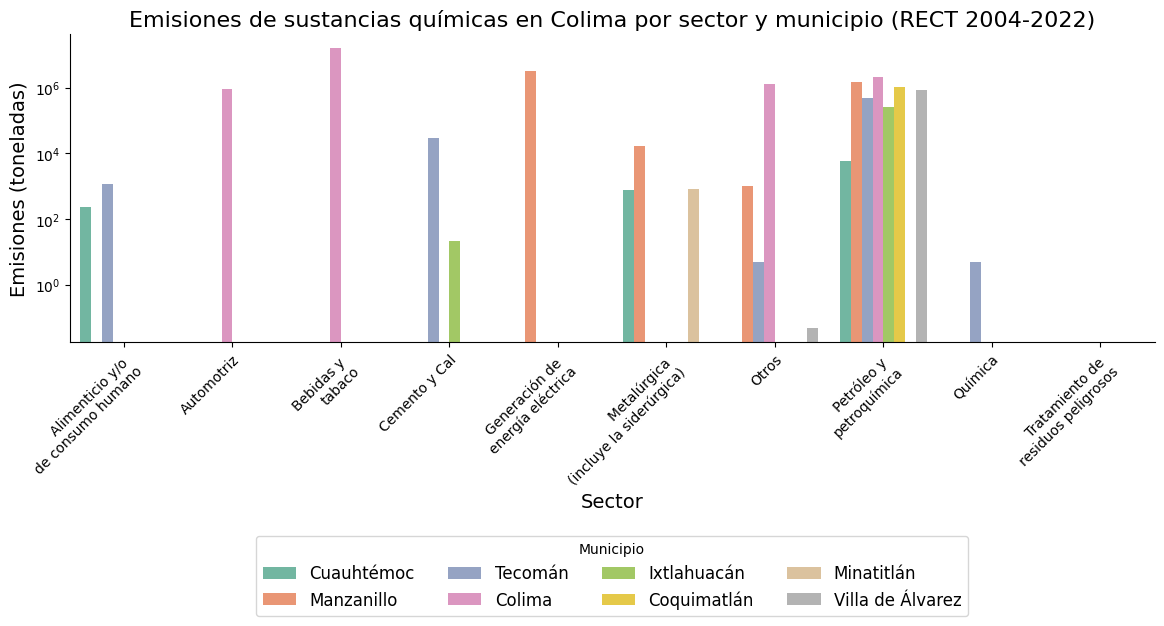

In [122]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector y municipio (RECT 2004-2022)", fontsize=16)

# generate a barplot with log scale and summing the values of "emision" column
sns.barplot(x="sector", y="emisiones", data=df2, hue="municipio", ax=ax, log=True, palette="Set2", estimator=sum)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

# add beautiful legend

# rotate xticks 90 degrees
plt.xticks(rotation=45)

ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.6), title='Municipio')



# wrap xticks labels
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
sns.despine()
plt.savefig('img/RETC_2004-2020/emisiones_sectores_mun.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
df3 = dfFinal2.groupby(by=['sector','sustancia'], as_index=False).agg({'emisiones':'sum'}).sort_values(by='emisiones', ascending=False)
df3.sort_values(by=['sector','sustancia'], inplace=True)

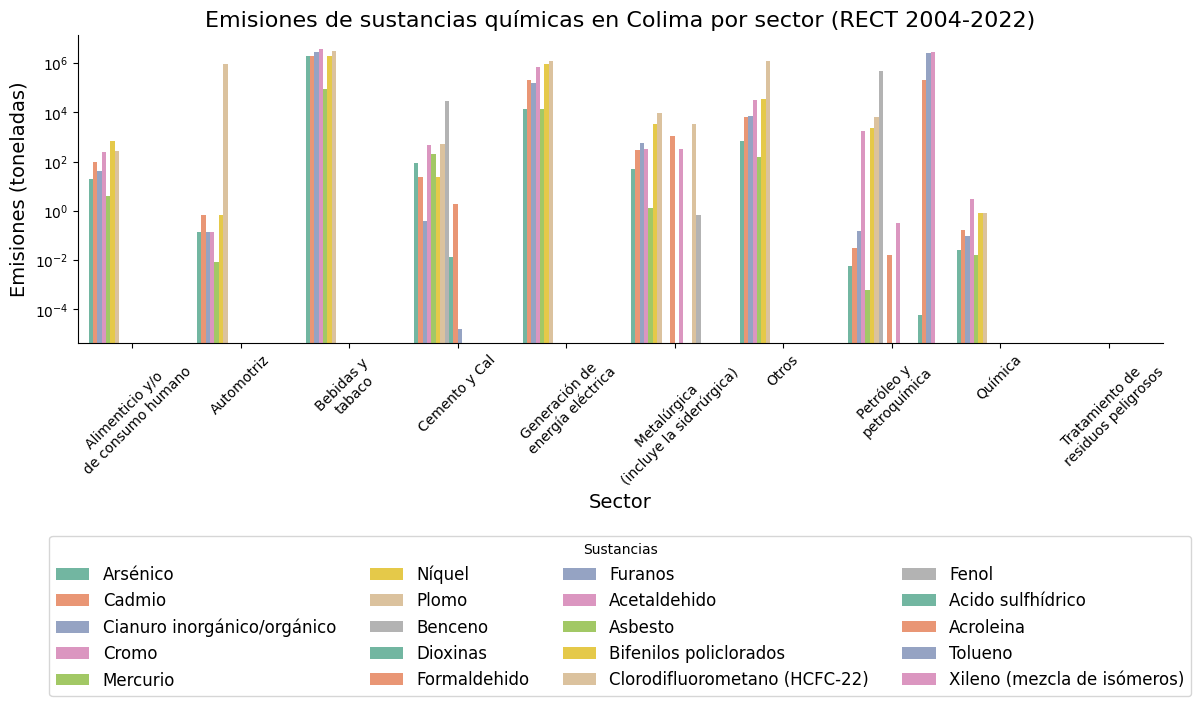

In [123]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="sector", y="emisiones", data=df3, hue="sustancia", ax=ax, log=True, palette="Set2")

# rotate xticks 90 degrees
plt.xticks(rotation=45)
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.6), title='Sustancias')

sns.despine()

plt.savefig('img/RETC_2004-2020/emisiones_sectores_sust.png', dpi=300, bbox_inches='tight')
plt.show()


In [126]:
df4 = dfFinal2.groupby(by=['nra','nombre', "sector"], as_index=False).agg({'emisiones':'sum'}).sort_values(by='emisiones', ascending=False)
df4.sort_values(by=['emisiones'], inplace=True, ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


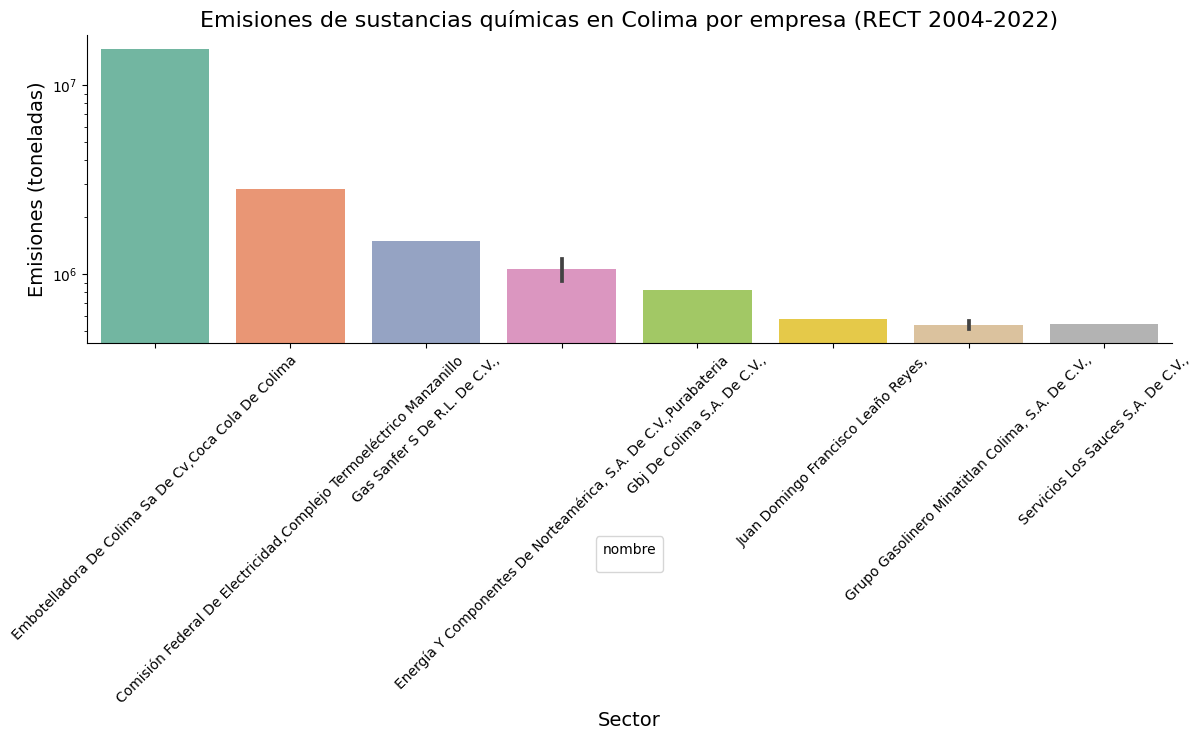

In [130]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por empresa (RECT 2004-2022)", fontsize=16)

sns.barplot(x="nombre", y="emisiones", data=df4.head(10), ax=ax, log=True, palette="Set2")

# rotate xticks 90 degrees
plt.xticks(rotation=45)
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.6), title='nombre')

sns.despine()

plt.show()


In [131]:
df4.nombre.unique()

array(['Embotelladora De Colima Sa De Cv,Coca Cola De Colima',
       'Comisión Federal De Electricidad,Complejo Termoeléctrico Manzanillo',
       'Gas Sanfer S De R.L. De C.V.,',
       'Energía Y Componentes De Norteamérica, S.A. De C.V.,Purabateria',
       'Gbj De Colima S.A. De C.V.,',
       'Juan Domingo Francisco Leaño Reyes,',
       'Grupo Gasolinero Minatitlan Colima, S.A. De C.V.,',
       'Servicios Los Sauces S.A. De C.V.,',
       'Comisión Federal De Electricidad,Comision Federal De Electricidad',
       'Ramcal Sa De Cv,', 'Gasolinera Chapalita S.A De C.V,',
       'Socombumex, S.A. De C.V.,Socombumex, S.A De C:V',
       'Servicio Ixtlahuacan S.A. De C.V.,',
       'Estacion De Servicio Valle Nuevo, S.A. De C.V.,Estacion De Servicio Valle Nuevo Sa De Cv E09507',
       'Pemex Refinacion Terminal De Almacenamiento Maritima Manzanillo',
       'Ecosistema De Colima S.A. De C.V.,Planta De Tratamiento De Aguas Residuales De Colima Y Villa De Alvarez',
       'Cementos Ap

In [89]:
gdf4 = gpd.GeoDataFrame(gdfEmpresas.merge(df4, on='nra', how='inner'), crs="EPSG:3857")

## save to gpkg file
gdf4.to_file("data/RETC_2004-2020/empresas_sector_emisiones.gpkg", driver="GPKG")
gdf4.head()

,nra,geometry,index_right,nombre,sector,emisiones
0,AAA0600700317,POINT (-11613993.397 2167236.424),0,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",Petróleo y \npetroquímica,7177.431900
1,AEL640600911,POINT (-11563683.171 2143819.761),0,Aceites Esenciales De Limon De Tecoman S.A De ...,Química,0.000323
2,AMAL70600711,POINT (-11608014.921 2162030.662),0,Aeropuerto De Manzanillo S.A. De C.V.,Otros,0.156580
3,CAP730600911,POINT (-11562941.041 2152417.882),0,Cementos Apasco S.A. De C.V.,Cemento y Cal,29945.925081
4,CAP730600911,POINT (-11562848.275 2152614.081),0,Cementos Apasco S.A. De C.V.,Cemento y Cal,29945.925081


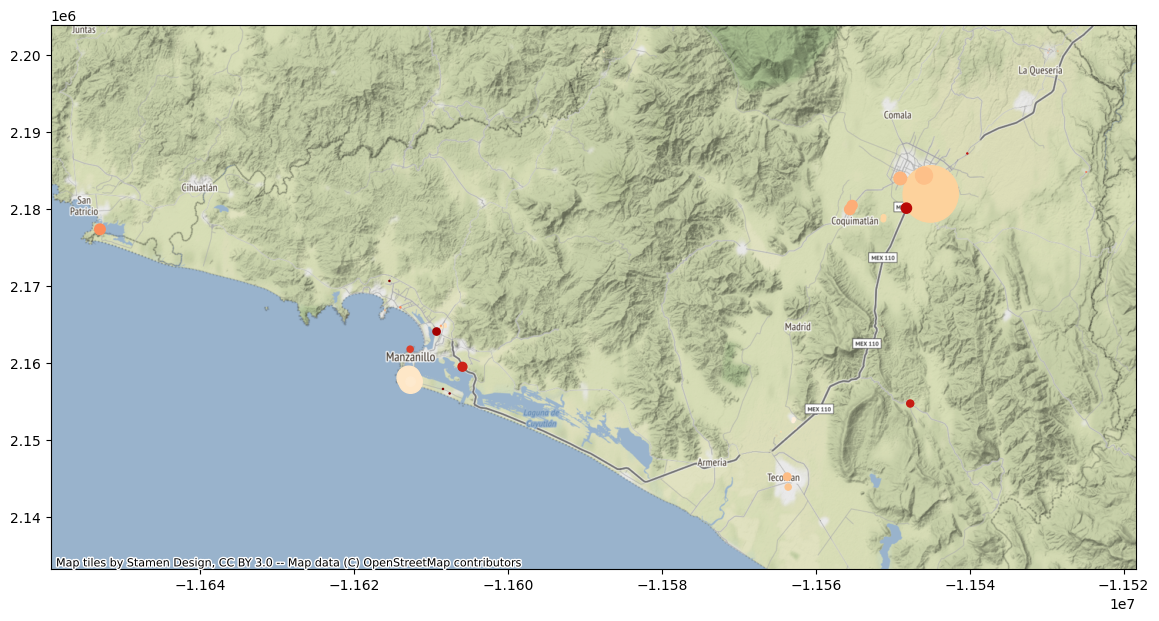

In [98]:
fig, ax = plt.subplots(figsize=(14, 10))

gdf4.plot(ax=ax, column='nombre', cmap='OrRd', markersize=gdf4['emisiones']*0.0001)

#plt.title("Emisiones de sustancias químicas en Colima por empresa (RECT 2004-2022)", fontsize=16)

#plt.savefig('img/RETC_2004-2020/emisiones_empresasssss.png', dpi=300, bbox_inches='tight')
# add basemap
ctx.add_basemap(ax)
plt.show()

In [124]:
df4.sort_values("emisiones", ascending=False, inplace=True)
gdf4.sort_values('emisiones', ascending=False, inplace=True)

c:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


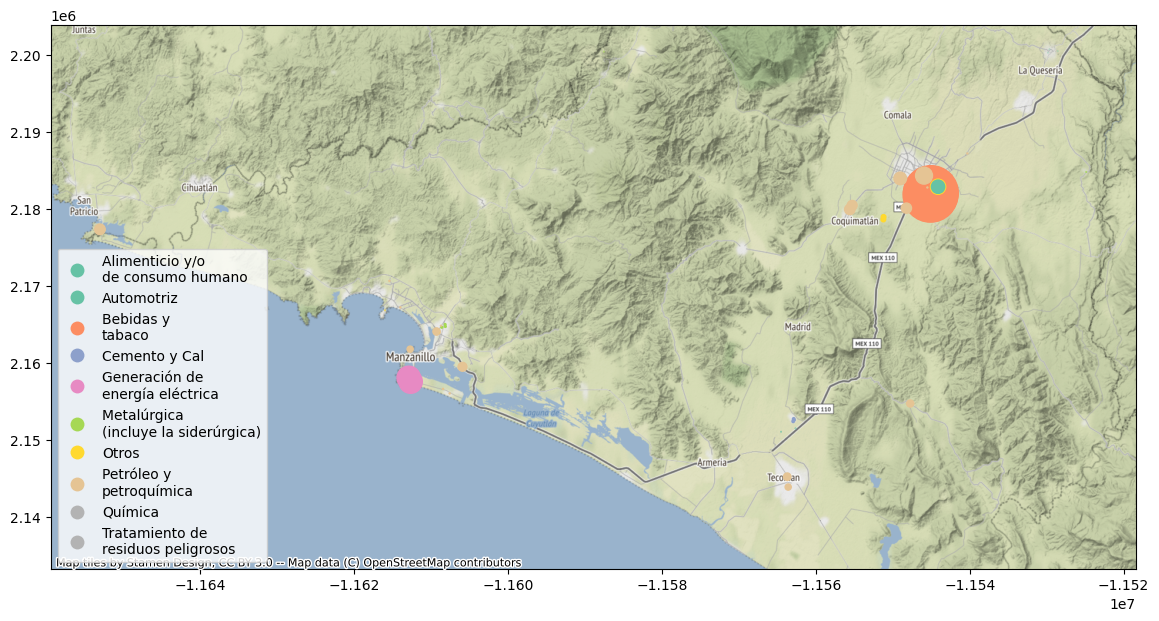

In [125]:
fig, ax = plt.subplots(figsize=(14, 10))

gdf4.plot(ax=ax, column='sector', markersize=gdf4['emisiones']*0.0001, legend=True, colormap="Set2")

#plt.title("Emisiones de sustancias químicas en Colima por empresa (RECT 2004-2022)", fontsize=16)

#plt.savefig('img/RETC_2004-2020/emisiones_empresasssss.png', dpi=300, bbox_inches='tight')
# add basemap
ctx.add_basemap(ax)
plt.show()

In [115]:
df4.groupby('sector').agg({"emisiones":"sum"})

,emisiones
sector,
Alimenticio y/o \nde consumo humano,1.378389e+03
Automotriz,9.183701e+05
Bebidas y \ntabaco,1.551411e+07
Cemento y Cal,2.997130e+04
Generación de \nenergía eléctrica,3.275875e+06
Metalúrgica \n(incluye la siderúrgica),1.861219e+04
Otros,1.311743e+06
Petróleo y \npetroquímica,6.156538e+06
Química,4.994199e+00


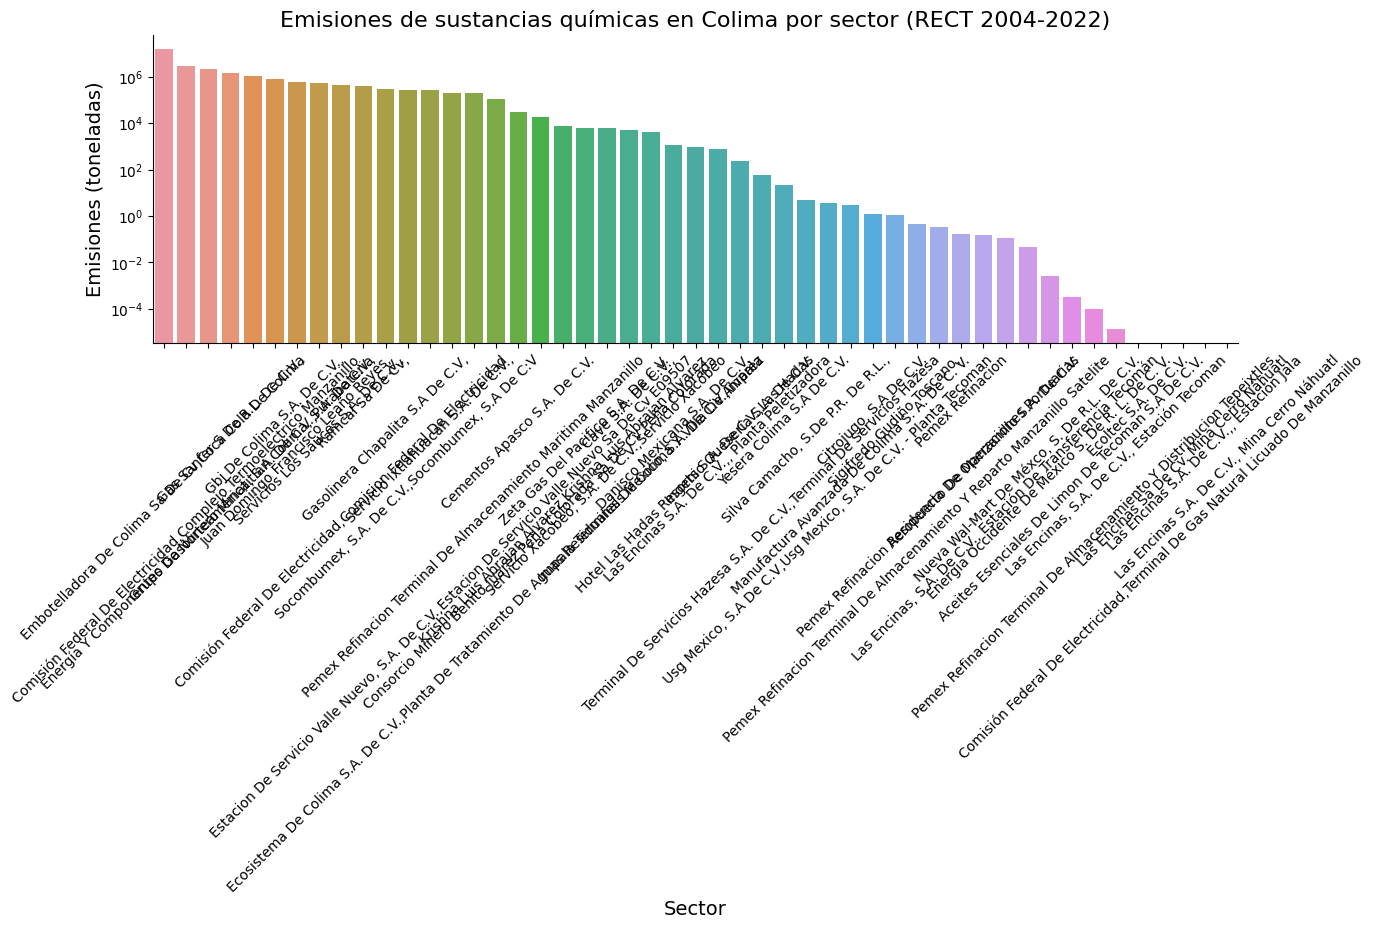

In [138]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="nombre", y="emisiones", data=df4.groupby('nombre', as_index=False).agg({"emisiones":"sum"}).sort_values('emisiones', ascending=False), ax=ax, log=True)

# rotate xticks 90 degrees
plt.xticks(rotation=45)
#ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

#ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.6), title='nombre')

sns.despine()
#plt.savefig('img/RETC_2004-2020/emisiones_sectores.png', dpi=300, bbox_inches='tight')
plt.show()


In [145]:
# add a \n to wrap the values in nombre column to fit in the plot 

#df4['nombre'] = df4['nombre'].apply(lambda x: x.replace(' ', '\n'))
df4['nombre'].apply(lambda x: x.replace(' ', '\n'))

15    Embotelladora\nDe\nColima\nSa\nDe\nCv,Coca\nCo...
5     Comisión\nFederal\nDe\nElectricidad,Complejo\n...
31                  Gas\nSanfer\nS\nDe\nR.L.\nDe\nC.V.,
14    Energía\nY\nComponentes\nDe\nNorteamérica,\nS....
13    Energía\nY\nComponentes\nDe\nNorteamérica,\nS....
28                     Gbj\nDe\nColima\nS.A.\nDe\nC.V.,
36              Juan\nDomingo\nFrancisco\nLeaño\nReyes,
30    Grupo\nGasolinero\nMinatitlan\nColima,\nS.A.\n...
48              Servicios\nLos\nSauces\nS.A.\nDe\nC.V.,
29    Grupo\nGasolinero\nMinatitlan\nColima,\nS.A.\n...
6     Comisión\nFederal\nDe\nElectricidad,Comision\n...
44                                  Ramcal\nSa\nDe\nCv,
27                 Gasolinera\nChapalita\nS.A\nDe\nC.V,
47    Socombumex,\nS.A.\nDe\nC.V.,Socombumex,\nS.A\n...
46               Servicio\nIxtlahuacan\nS.A.\nDe\nC.V.,
26    Estacion\nDe\nServicio\nValle\nNuevo,\nS.A.\nD...
42    Pemex\nRefinacion\nTerminal\nDe\nAlmacenamient...
17    Ecosistema\nDe\nColima\nS.A.\nDe\nC.V.,Pla

In [143]:
{value:value for (_,value) in df4.nombre.items()}

{'Embotelladora De Colima Sa De Cv,Coca Cola De Colima': 'Embotelladora De Colima Sa De Cv,Coca Cola De Colima',
 'Comisión Federal De Electricidad,Complejo Termoeléctrico Manzanillo': 'Comisión Federal De Electricidad,Complejo Termoeléctrico Manzanillo',
 'Gas Sanfer S De R.L. De C.V.,': 'Gas Sanfer S De R.L. De C.V.,',
 'Energía Y Componentes De Norteamérica, S.A. De C.V.,Purabateria': 'Energía Y Componentes De Norteamérica, S.A. De C.V.,Purabateria',
 'Gbj De Colima S.A. De C.V.,': 'Gbj De Colima S.A. De C.V.,',
 'Juan Domingo Francisco Leaño Reyes,': 'Juan Domingo Francisco Leaño Reyes,',
 'Grupo Gasolinero Minatitlan Colima, S.A. De C.V.,': 'Grupo Gasolinero Minatitlan Colima, S.A. De C.V.,',
 'Servicios Los Sauces S.A. De C.V.,': 'Servicios Los Sauces S.A. De C.V.,',
 'Comisión Federal De Electricidad,Comision Federal De Electricidad': 'Comisión Federal De Electricidad,Comision Federal De Electricidad',
 'Ramcal Sa De Cv,': 'Ramcal Sa De Cv,',
 'Gasolinera Chapalita S.A De C.V,':

In [140]:
df4.nombre.items()

In [139]:
df4.nombre.unique()

array(['Embotelladora De Colima Sa De Cv,Coca Cola De Colima',
       'Comisión Federal De Electricidad,Complejo Termoeléctrico Manzanillo',
       'Gas Sanfer S De R.L. De C.V.,',
       'Energía Y Componentes De Norteamérica, S.A. De C.V.,Purabateria',
       'Gbj De Colima S.A. De C.V.,',
       'Juan Domingo Francisco Leaño Reyes,',
       'Grupo Gasolinero Minatitlan Colima, S.A. De C.V.,',
       'Servicios Los Sauces S.A. De C.V.,',
       'Comisión Federal De Electricidad,Comision Federal De Electricidad',
       'Ramcal Sa De Cv,', 'Gasolinera Chapalita S.A De C.V,',
       'Socombumex, S.A. De C.V.,Socombumex, S.A De C:V',
       'Servicio Ixtlahuacan S.A. De C.V.,',
       'Estacion De Servicio Valle Nuevo, S.A. De C.V.,Estacion De Servicio Valle Nuevo Sa De Cv E09507',
       'Pemex Refinacion Terminal De Almacenamiento Maritima Manzanillo',
       'Ecosistema De Colima S.A. De C.V.,Planta De Tratamiento De Aguas Residuales De Colima Y Villa De Alvarez',
       'Cementos Ap

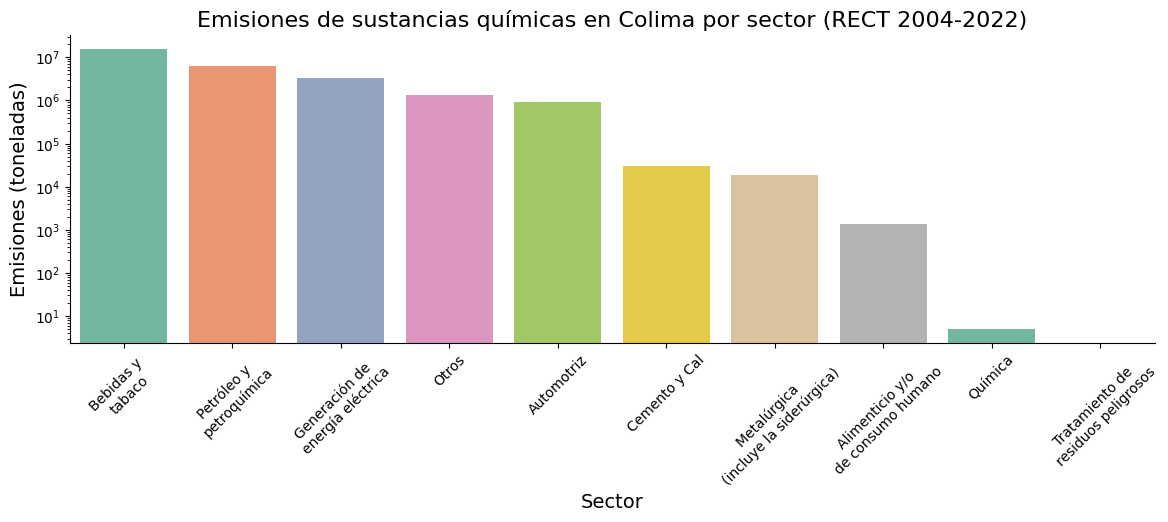

In [136]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="sector", y="emisiones", data=df4.groupby('sector', as_index=False).agg({"emisiones":"sum"}).sort_values('emisiones', ascending=False), ax=ax, log=True, palette="Set2")

# rotate xticks 90 degrees
plt.xticks(rotation=45)
#ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

#ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.6), title='nombre')

sns.despine()
plt.savefig('img/RETC_2004-2020/emisiones_sectores.png', dpi=300, bbox_inches='tight')
plt.show()


## Emisiones según el tipo de transferencia

In [149]:
['col'] + col_transferencia

['col',
 'reciclado',
 'coprocesamiento',
 'tratamiento',
 'disposición final',
 'alcantarillado',
 'otro',
 'incineración',
 'reutilización']

In [147]:
dfFinal2.head()

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia,emisiones
0,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Xileno (mezcla de isómeros),1330-20-7,0.001,1320.1100,0.0,0.0,...,0.0,0.0,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,1320.1100
1,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Benceno,71-43-2,0.001,543.0200,0.0,0.0,...,0.0,0.0,0.0,0.0,2017,Manzanillo,0.0,NaN,NaN,543.0200
2,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Benceno,71-43-2,0.001,888.5019,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,888.5019
3,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Tolueno,108-88-3,0.001,1309.8600,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,1309.8600
4,AAA0600700317,"Krishna Luis Abrajan Alvarez,Krishna Luis Abra...",COLIMA,Petróleo y \npetroquímica,Xileno (mezcla de isómeros),1330-20-7,0.001,2058.4200,0.0,0.0,...,0.0,0.0,0.0,0.0,2018,Manzanillo,0.0,NaN,NaN,2058.4200


In [154]:
dfTransferencia = dfFinal2[["municipio"]+col_transferencia]

# wide to long 
dfTransferencia = pd.melt(dfTransferencia, id_vars=["municipio"], var_name="transferencia", value_name="emisiones")

# group by municipio and transferencia and sum emisiones  
dfTransferencia = dfTransferencia.groupby(["municipio", "transferencia"], as_index=False).agg({"emisiones":"sum"})
dfTransferencia

,municipio,transferencia,emisiones
0,Colima,alcantarillado,0.0000
1,Colima,coprocesamiento,1.5810
2,Colima,disposición final,7.7000
3,Colima,incineración,0.0000
4,Colima,otro,925065.6589
...,...,...,...
59,Villa de Álvarez,incineración,0.0000
60,Villa de Álvarez,otro,0.0000
61,Villa de Álvarez,reciclado,0.0000
62,Villa de Álvarez,reutilización,0.0000


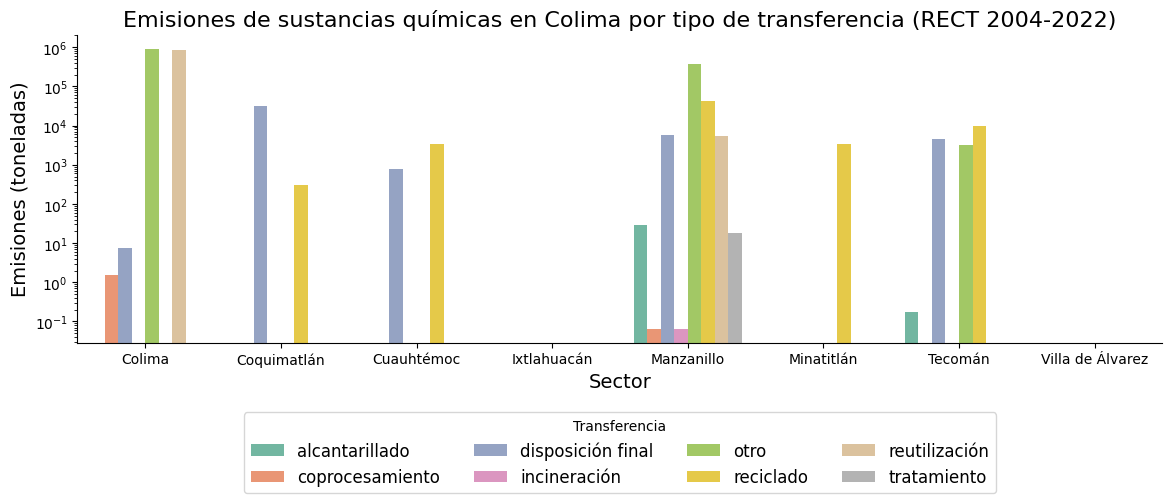

In [162]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por tipo de transferencia (RECT 2004-2022)", fontsize=16)

sns.barplot(x="municipio", y="emisiones",hue='transferencia', data=dfTransferencia, ax=ax, log=True, palette="Set2")

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

ax.legend(loc='upper center', ncol=4,  fontsize=12, bbox_to_anchor=(0.5, -0.2), title='Transferencia')

sns.despine()
plt.savefig('img/RETC_2004-2020/emisiones_transferencia.png', dpi=300, bbox_inches='tight')
plt.show()

## Lineas de tiempo

In [165]:
df6 = dfFinal2.groupby(["municipio", "sustancia","year"], as_index=False).agg({"emisiones":"sum"})
df6

,municipio,sustancia,year,emisiones
0,Colima,Acetaldehido,2008,0.029823
1,Colima,Acetaldehido,2011,0.029823
2,Colima,Acetaldehido,2012,0.012790
3,Colima,Acetaldehido,2013,0.023704
4,Colima,Acroleina,2008,0.003596
...,...,...,...,...
511,Villa de Álvarez,Plomo,2013,0.047027
512,Villa de Álvarez,Tolueno,2018,196390.000000
513,Villa de Álvarez,Tolueno,2019,167380.000000
514,Villa de Álvarez,Xileno (mezcla de isómeros),2018,213280.000000


In [166]:
nMun = len(df6.municipio.unique())
nMun

8

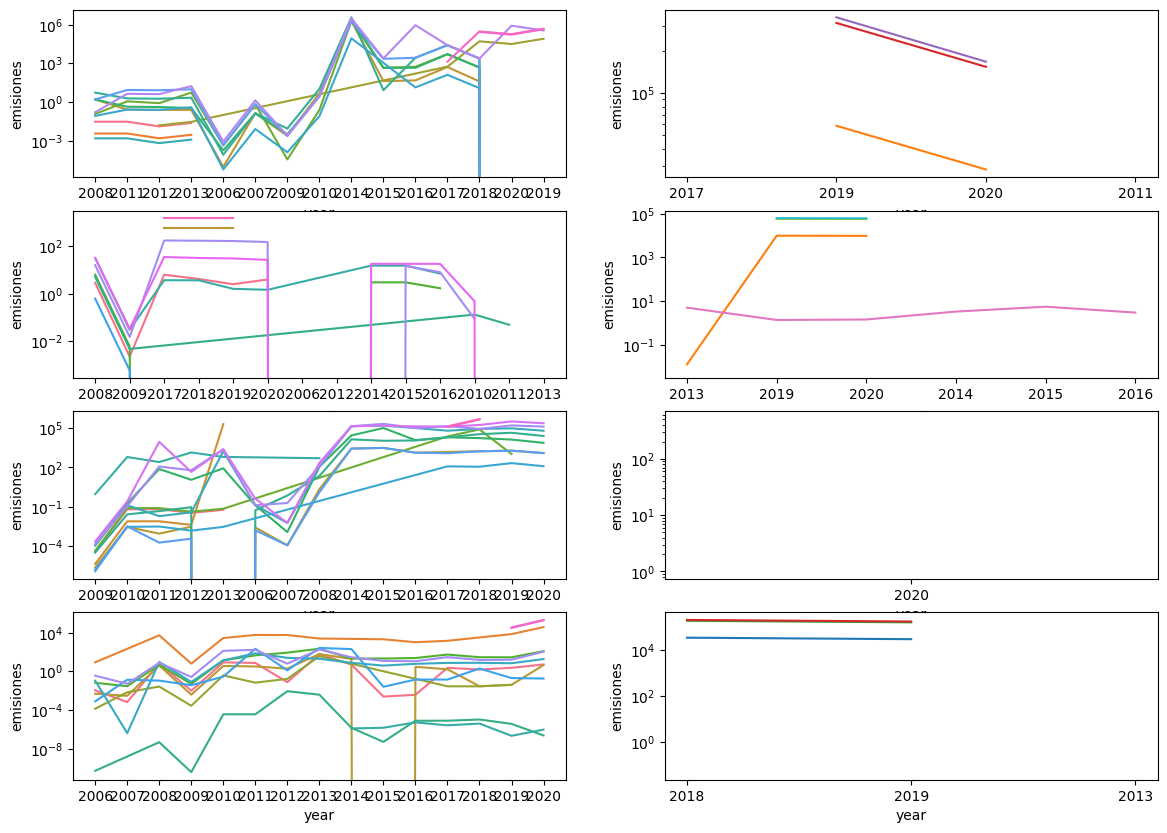

In [172]:
fig, ax = plt.subplots(figsize=(14, 10), ncols=2, nrows=4)

row, col = 0, 0

for mun, munDF in df6.groupby('municipio'):
    #munDF.plot(x="year", y="emisiones", ax=ax[row, col], legend=False, logy=True, title=mun)
    
    sns.lineplot(x="year", y="emisiones",hue='sustancia', data=munDF, ax=ax[row, col], legend=False)
    
    # set log scale
    ax[row, col].set_yscale('log')
    
    col += 1
    if col == 2:
        col = 0
        row += 1

## Solo sector

In [38]:
df5 = dfFinal2.groupby(by=['sector'], as_index=False).agg({'emisiones':'sum'}).sort_values(by='emisiones', ascending=False)
df5.sort_values(by=['sector'], inplace=True)

In [39]:
df5

,sector,emisiones
0,Alimenticio y/o \nde consumo humano,1.378389e+03
1,Automotriz,9.183701e+05
2,Bebidas y \ntabaco,1.551411e+07
3,Cemento y Cal,2.997130e+04
4,Generación de \nenergía eléctrica,3.275875e+06
5,Metalúrgica \n(incluye la siderúrgica),1.861219e+04
6,Otros,1.311743e+06
7,Petróleo y \npetroquímica,6.156538e+06
8,Química,4.994199e+00
9,Tratamiento de \nresiduos peligrosos,0.000000e+00


In [40]:
dfFinal2.columns

Index(['nra', 'nombre', 'estado', 'sector', 'sustancia', 'cas', 'unidad',
       'aire', 'agua', 'suelo', 'reuso', 'reciclado', 'coprocesamiento',
       'tratamiento', 'disposición final', 'alcantarillado', 'otro',
       'incineración', 'year', 'municipio', 'reutilización', 'establecimiento',
       'grupo sustancia', 'emisiones'],
      dtype='object')